# Objectives:
We need to build medical vocabulary (word dictionary) for spelling checker. The following dataset was found useful for building vocab:(https://www.kaggle.com/datasets/jpmiller/layoutlm/data)

Before building the vocab, the following questions needs to be clarified:
1. What the dataset contains (EDA)?
2. Which feature needed?
3. What is the expected outcome?

Once, these questions are clarified, we can proceed building a custom NLTK corpus.

In [31]:
import pandas as pd
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
import statistics

from nltk.translate.bleu_score import corpus_bleu

In [32]:
df = pd.read_csv('data/medquad-kaggle-johnm.csv')

In [33]:
df.shape

(16412, 4)

In [34]:
df.head(2)

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma


## 1. What the dataset contains?
We need a corpus that contains medical words for building a medical dictionary (vocab). Therefore, we need to investigate whether the obtained corpus contains the required.

In [35]:
# Let's investigate the data types and columns in the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


In [36]:
# It appears there are four columns, and all columns contains string datatype.
# Let's investigate which column will be more sensible for building the vocab.
df.describe()

,question,answer,source,focus_area
count,16412,16407,16412,16398
unique,14984,15817,9,5126
top,What causes Causes of Diabetes ?,This condition is inherited in an autosomal re...,GHR,Breast Cancer
freq,20,348,5430,53


Logically assumption: average length of answers should be greater than questions; means, more texts in answers column. \
Let's investigate the assumption.


In [37]:
# The following function returns token count for given text, it will be used for calculating
# average tokens for questions & answers.
def token_count(x):
    return len(word_tokenize(x))

Before we use the word_tokenizer to count the tokens in each column, we need to drop the missing values to avoid exceptions.

In [38]:
# Let's find out the missing values first.
df.isnull().sum()

question       0
answer         5
source         0
focus_area    14
dtype: int64

In [39]:
# From the above we can conclude, question column doesn't have missing values meanwhile, answer column have 5.
cnt = df['question'].apply(token_count).sum()
print(f'Questions have {cnt} count of tokens.')

Questions have 146185 count of tokens.


In [40]:
# Drop only rows with missing values on the answer columns.
df = df[df['answer'].notna()]

cnt = df['answer'].apply(token_count).sum()
print(f'Answers have {cnt} count of tokens.')

Answers have 3731909 count of tokens.


## 2. Which feature needed?
In the EDA, two columns (question & answer) from the dataset was expected to have the required texts to build the vocab. For that, an hypothesis made that the answer column would have longer text than question column. The hypothesis was true, and therefore, the text from the answer column will be preprocessed for building the corpus.\

In the preprocessing to build the vocab, we need to:
1. Clean the text from answer column - only words (others are stripped)
2. Get lemma for each words to avoid redundant word with the same meaning
3. Only include unique words into vocab

In [41]:
# 1. Clean the text from answer column - only words (others are stripped)
from nltk.corpus import stopwords
import re

# Define the regex pattern for removing URLs.
url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

html_regex = r"<[^/>][^>]*>"

# Acquire the stop words from NLTK corpus.
stop_words = stopwords.words('english')

# To store all the processed tokens.
corpus_token_list = []

# Tracing value for debugging.
i = 0
token_cnt = 0
filtered_token_cnt = 0
try:
    for text in df['answer']:
        # Remove URLs.
        clean_text = re.sub(url_regex, '', text)
        # Remove HTML tags.
        clean_text = re.sub(html_regex, '', clean_text)
        # Only select words.
        clean_text = re.sub(r'[^a-z]', ' ', clean_text.lower())

        # Tokenize the text.
        tokens = word_tokenize(clean_text)

        # Tracing unfiltered-token count.
        token_cnt += len(tokens)

        # Filter stop words.
        filtered_text = [w for w in tokens if not w.lower() in stop_words]

        # Tracing filtered-token count for debugging.
        filtered_token_cnt += len(filtered_text)

        # Add the filtered words into corpus token_list.
        corpus_token_list.append(filtered_text)

        # Tracing row-count for debugging.
        i += 1
except Exception as e:
    print(f'Exception {e.message} in {i}.')

print(f'Rows processed:[{i}], unfiltered tokens:[{token_cnt}], filtered tokens:[{filtered_token_cnt}]')
print(f'Corpus entry count:[{len(corpus_token_list)}].')

Rows processed:[16407], unfiltered tokens:[3236280], filtered tokens:[1947878]
Corpus entry count:[16407].


In [42]:
# 2. Get lemma for each words to avoid redundant word with the same meaning
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# List for storing token's lemma.
corpus_lemma_list = []

# Tracing value for debugging.
i = 0
token_cnt = 0
filtered_token_cnt = 0
for entry in corpus_token_list:
    entry_list = []
    for token in entry:
        entry_list.append(lemmatizer.lemmatize(token))
        filtered_token_cnt += 1

    # Add entry (token for single answer) in the list for further processing.
    corpus_lemma_list.append(entry_list)
    i = i + 1

print(f'Rows processed:[{i}], filtered tokens:[{filtered_token_cnt}]')
print(f'Corpus entry count:[{len(corpus_token_list)}].')

Rows processed:[16407], filtered tokens:[1947878]
Corpus entry count:[16407].


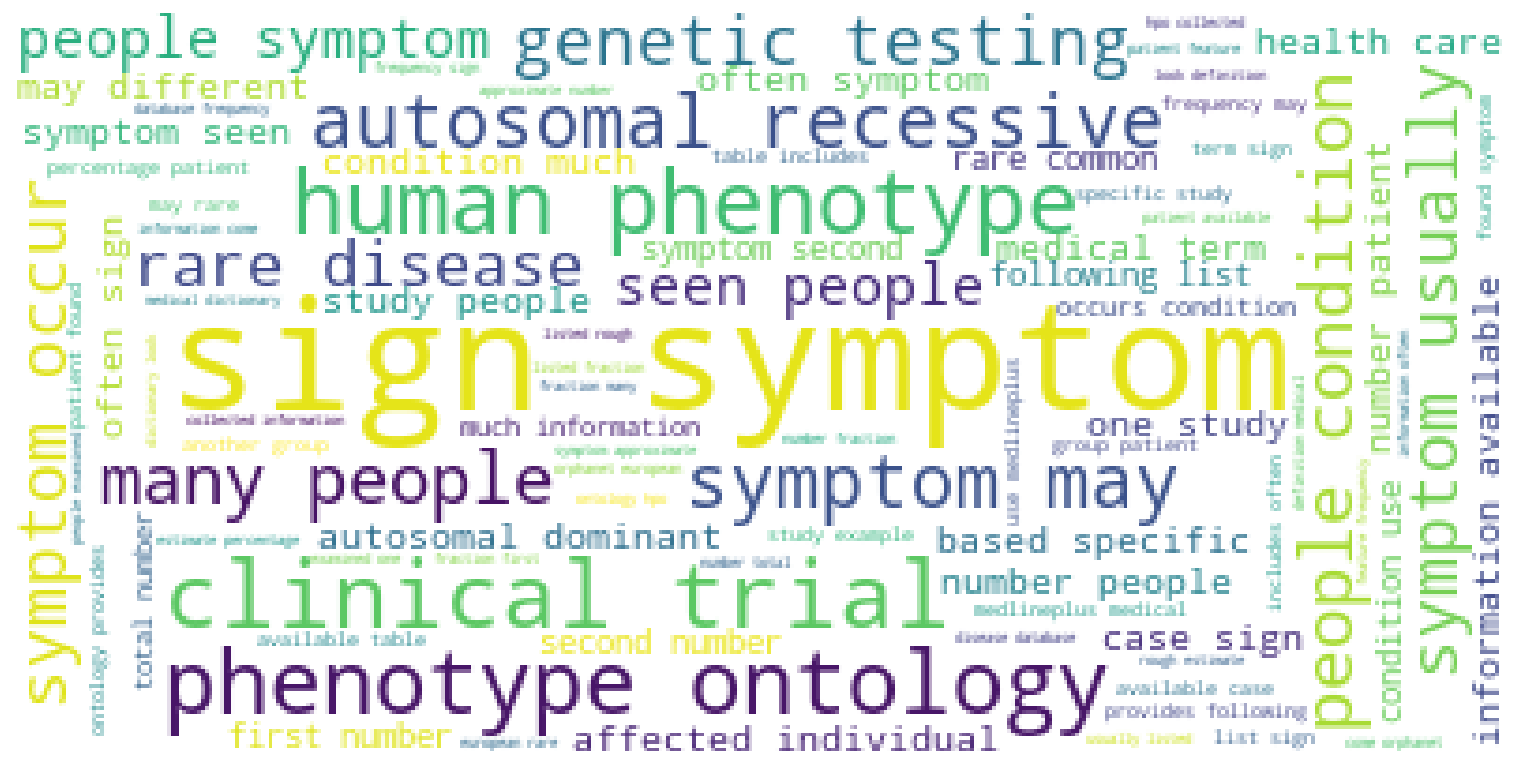

In [43]:
# Let's see the most frequent words in the vocab.
import wordcloud
import matplotlib.pyplot as plt

text = ''
for entry in corpus_lemma_list:
    for token in entry:
        text += ' ' + token

word_cloud = wordcloud.WordCloud(background_color='white').generate(text)
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [44]:
# 3. Only include unique words into vocab

# Final vocab to store the lemmas from the corpus.
vocab_list = []
for entry in corpus_lemma_list:
    for word in entry:
        if word not in vocab_list:
            vocab_list.append(word)

print(f'Vocab entry count (unique words):[{len(vocab_list)}].')

Vocab entry count (unique words):[24561].


## 3. What is the expected outcome?
Now, we have the unique medical words stored in vocab and ready for creating a NLTK corpus for spelling checking.

In [45]:
# Save the vocab into custom NLTK corpus format.

import os

# Organize the vocab into custom folder.
corpus_dir = 'corpus/med'
if not os.path.exists(corpus_dir):
    os.makedirs(corpus_dir)

# Write words (lemma) to separate files in the corpus directory.
for i, text in enumerate(vocab_list):
    with open(os.path.join(corpus_dir, f'doc{i + 1}.txt'), 'w', encoding='utf-8') as file:
        file.write(text)

In [46]:
# Load the custom NLTK corpus.
from nltk.corpus import PlaintextCorpusReader

# Step 3: Create an NLTK Corpus Reader
corpus = PlaintextCorpusReader(corpus_dir, '.*\.txt')

print(f'There are {len(corpus.words())} words in custom corpus.')

There are 24561 words in custom corpus.


In [47]:
from nltk import edit_distance

i = 0
test_word = 'glacoma'

if test_word not in corpus.words():
    print(f'Test word {test_word} not in corpus.')
    for w in corpus.words():
        m = edit_distance(test_word, w)
        if m == 1:
            print(f'Word {w} edit distance is {m}.')
            break
else:
    print(f'Test word {test_word} exists in corpus.')


Test word glacoma not in corpus.
Word glaucoma edit distance is 1.
